# Sentiment Analysis of Emotions

## Introduction

The aim of this project is to classify emotions from text data using four machine learning models: **Naive Bayes**, **Logistic Regression**, **Random Forest**, and **Support Vector Machine (SVM)**. Sentiment analysis, in the context of emotion classification, involves categorizing text based on the emotional tone it conveys. This has wide applications in customer service, social media monitoring, and emotional intelligence systems.

#### Models Overview

* **Naive Bayes**: A probabilistic classifier based on Bayes' Theorem, Naive Bayes assumes that the features (words) in the data are independent given the class (emotion). It is efficient and performs well with high-dimensional data like text, making it an excellent choice for text classification tasks, especially when the data is noisy.

* **Logistic Regression**: This is a linear model for binary and multi-class classification problems. Logistic regression models the probability that a given input belongs to a particular class. It is a well-known and simple algorithm often used in text classification problems, particularly when the relationships between features and the target variable are assumed to be linear.

* **Random Forest**: An ensemble learning method that constructs multiple decision trees and merges them to get a more accurate and stable prediction. It works well for complex datasets and is less prone to overfitting compared to a single decision tree. Random Forest is known for handling a large number of features, making it suitable for text data with many dimensions.

* **Support Vector Machine (SVM)**: A powerful classifier that works by finding the optimal hyperplane that separates the classes in high-dimensional space. SVM can efficiently handle both linear and non-linear data through kernel tricks, making it ideal for text data where class separation is complex.

#### Evaluation Metrics
In this project, we evaluate and compare the performance of the models using the following metrics:
* **Accuracy**: The percentage of correctly classified instances out of all instances.

* **Precision**: The ratio of correctly predicted positive instances to the total predicted positive instances, which indicates how reliable the model’s positive predictions are.

* **Recall (Sensitivity)**: The ratio of correctly predicted positive instances to all actual positive instances, indicating how well the model identifies positive instances.

* **F1 Score**: The harmonic mean of precision and recall, providing a single metric to evaluate the balance between them.

* **Confusion Matrix**: A matrix that shows the true vs. predicted classifications for each emotion label, offering insight into model performance for each class.

We will evaluate these models on emotion-labeled datasets and compare their performance based on these metrics to identify the best-performing model for emotion classification.

### 1. Importing Libraries and Loading Data

#### 1.1 Importing Libraries

In [242]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
from bs4 import BeautifulSoup
from wordcloud import WordCloud

# Libraries for NLP and model building
import nltk
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

from collections import Counter


#### 1.2 Importing Dataset

In [244]:
# df = pd.read_csv('./dataset/train.csv')

In [245]:
# Load the test.txt dataset
df = pd.read_csv('./dataset/train.txt', names=['Text', 'Emotion'], sep=';')

In [246]:
# Display the first few rows of the dataset
df.head()

,Text,Emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [247]:
# Print the shape of the dataset (number of rows and columns)
print(df.shape)

(16000, 2)


### 2. Data Preprocessing

#### 2.1 Cleaning the Data

Remove the HTML tags, URL patters, unwanted patters, special characters and numbers, and removal of stopwords

In [251]:
# Function to clean the text
def clean_text(text):
    # # Remove HTML tags using BeautifulSoup (in case some tags are still in text form)
    # text = BeautifulSoup(text, "html.parser").get_text()

    # # Remove any URL patterns (http, https, ftp, etc.)
    # text = re.sub(r'http[s]?://\S+', '', text)
    
    # Remove any other unwanted patterns like href, src, etc.
    text = re.sub(r'\b(?:href|src|alt|title|class|id|style|rel|data|http|https|src|www|img)\b', '', text)

    # Remove special characters and numbers (keeping only alphabets and spaces)
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Convert to lowercase
    text = text.lower()

    # Remove stopwords (optional, can be added if you have a stopwords list)
    stop_words = set(stopwords.words('english'))
    text = ' '.join(word for word in text.split() if word not in stop_words)

    return text

# Apply the cleaning function to the 'Text' column
df['Cleaned_Text'] = df['Text'].apply(clean_text)
# Save the cleaned DataFrame to a CSV file
df.to_csv('./dataset/cleaned_data.csv', index=False)

In [252]:
# Display cleaned text
df[['Text', 'Cleaned_Text']].head()

,Text,Cleaned_Text
0,i didnt feel humiliated,didnt feel humiliated
1,i can go from feeling so hopeless to so damned...,go feeling hopeless damned hopeful around some...
2,im grabbing a minute to post i feel greedy wrong,im grabbing minute post feel greedy wrong
3,i am ever feeling nostalgic about the fireplac...,ever feeling nostalgic fireplace know still pr...
4,i am feeling grouchy,feeling grouchy


#### 2.2 Emotion Distribution using Pie Chart

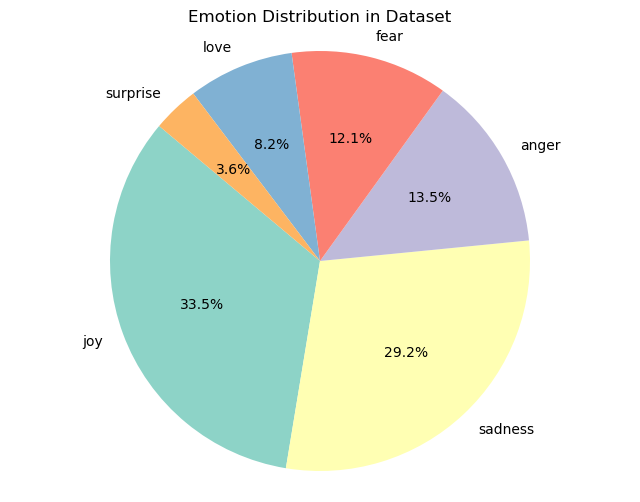

In [254]:
# Display a pie chart of emotion counts
emotion_counts = df['Emotion'].value_counts()

# Create the pie chart
plt.figure(figsize=(8, 6))
plt.pie(emotion_counts, labels=emotion_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set3", len(emotion_counts)))
plt.title('Emotion Distribution in Dataset')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is circular.
plt.show()

#### 2.3 Emotion Counts using Bar Chart

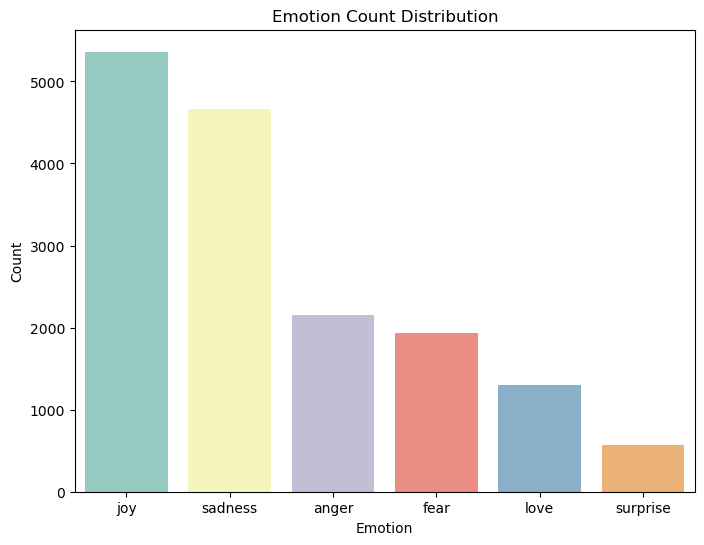

In [256]:
# Display emotion counts
emotion_counts = df['Emotion'].value_counts()

# Convert the emotion counts to a DataFrame for use in seaborn
emotion_counts_df = emotion_counts.reset_index()
emotion_counts_df.columns = ['Emotion', 'Count']

# Bar chart with hue assigned
plt.figure(figsize=(8, 6))
sns.barplot(x='Emotion', y='Count', data=emotion_counts_df, palette="Set3", hue='Emotion')
plt.title('Emotion Count Distribution')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

#### 2.4 Word Cloud

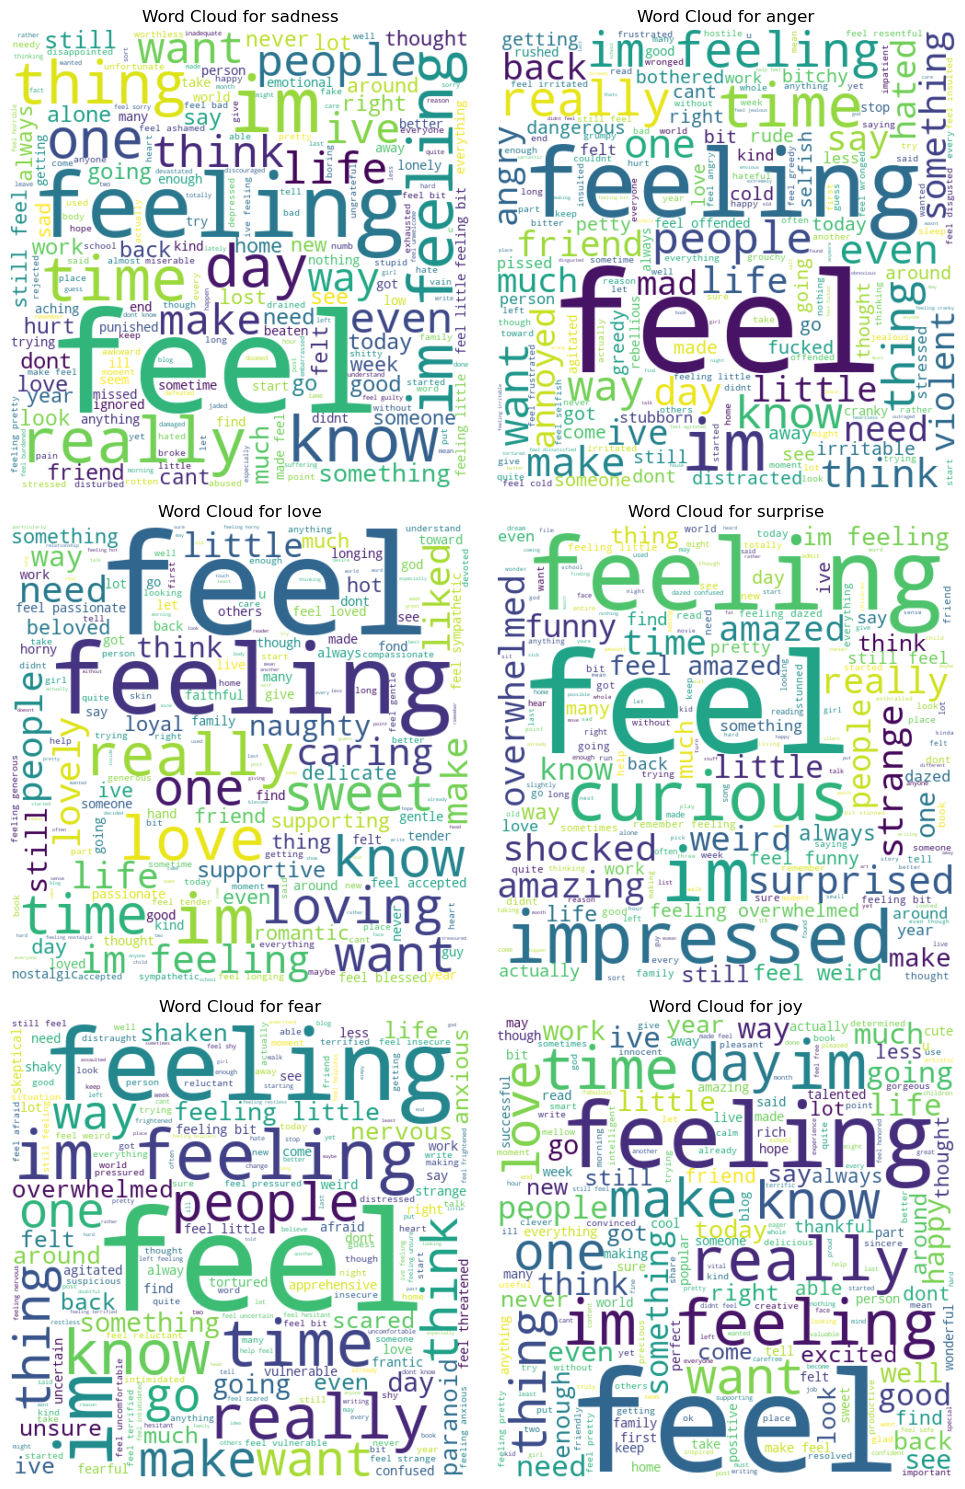

In [258]:
# Generate word clouds for each emotion category
unique_emotions = df['Emotion'].unique()

# Dynamically calculate the number of rows and columns for the subplots
num_emotions = len(unique_emotions)
cols = 2  # Fixed number of columns (you can adjust this)
rows = np.ceil(num_emotions / cols).astype(int)  # Calculate the required rows

# Create a plot for each emotion category
plt.figure(figsize=(10, 5 * rows))
for i, emotion in enumerate(unique_emotions, 1):
    # Filter the DataFrame for the current emotion
    emotion_text = df[df['Emotion'] == emotion]['Cleaned_Text'].str.cat(sep=' ')

    # Generate the word cloud
    wordcloud = WordCloud(width=500, height=500, background_color='white', max_words=200).generate(emotion_text)

    # Display the word cloud
    plt.subplot(rows, cols, i)  # Dynamically adjust subplots based on the number of categories
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {emotion}')

plt.tight_layout()
plt.show()

#### 2.5 Label Encoding

In [260]:
# Convert categorical emotions to numerical values
label_encoder = LabelEncoder()
df['Emotion_Label'] = label_encoder.fit_transform(df['Emotion'])

# Display the mapping of labels
print(dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))

{'anger': 0, 'fear': 1, 'joy': 2, 'love': 3, 'sadness': 4, 'surprise': 5}


In [261]:
df[['Cleaned_Text', 'Emotion', 'Emotion_Label']].head()

,Cleaned_Text,Emotion,Emotion_Label
0,didnt feel humiliated,sadness,4
1,go feeling hopeless damned hopeful around some...,sadness,4
2,im grabbing minute post feel greedy wrong,anger,0
3,ever feeling nostalgic fireplace know still pr...,love,3
4,feeling grouchy,anger,0


### 3. Splitting the Data

#### 3.1 Perform stratified sampling 
##### Stratified sampling ensures that the distribution of emotion labels in the dataset is preserved across training and test sets. This is critical since some emotions, like "surprise," may be underrepresented.

In [264]:
X_train, X_test, y_train, y_test = train_test_split(
    df['Cleaned_Text'],
    df['Emotion_Label'],
    test_size = 0.2,
    random_state = 42,
    stratify = df['Emotion_Label'],
)

In [265]:
# Check class distribution after splitting
print("Training class distribution:", y_train.value_counts())
print("Testing class distribution:", y_test.value_counts())

Training class distribution: Emotion_Label
2    4290
4    3733
0    1727
1    1550
3    1043
5     457
Name: count, dtype: int64
Testing class distribution: Emotion_Label
2    1072
4     933
0     432
1     387
3     261
5     115
Name: count, dtype: int64


In [266]:
# Verify the distribution
print("Training set distribution:")
print(y_train.value_counts(normalize=True))

print("\nTest set distribution:")
print(y_test.value_counts(normalize=True))

Training set distribution:
Emotion_Label
2    0.335156
4    0.291641
0    0.134922
1    0.121094
3    0.081484
5    0.035703
Name: proportion, dtype: float64

Test set distribution:
Emotion_Label
2    0.335000
4    0.291563
0    0.135000
1    0.120938
3    0.081562
5    0.035937
Name: proportion, dtype: float64


#### 3.2 Up/down sampling for trainset

##### Undersampling Majority Classes

In [284]:
# Convert the training data into a DataFrame for easier manipulation
train_df = pd.DataFrame({'Text': X_train, 'Emotion_Label': y_train})

# Calculate class counts
class_counts = train_df['Emotion_Label'].value_counts()

# Define the new adjustments (increases for anger, fear, love, and especially surprise)
adjustments = {
    0: -0.45,  # Anger
    1: -0.35,  # Fear
    2: -0.75,  # Joy
    3: 0,  # Love
    4: -0.73,  # Sadness
    5: 1.30   # Surprise
}

# Create an empty DataFrame to store the adjusted data
adjusted_train_df = pd.DataFrame()

# Perform adjustments for each class
for label, adjustment in adjustments.items():
    subset = train_df[train_df['Emotion_Label'] == label]
    n_samples = int(len(subset) * (1 + adjustment))
    
    if adjustment > 0:  # Oversampling
        # Randomly sample with replacement
        resampled_subset = subset.sample(n=n_samples, replace=True, random_state=42)
    else:  # Undersampling
        # Randomly sample without replacement
        resampled_subset = subset.sample(n=n_samples, replace=False, random_state=42)
    
    adjusted_train_df = pd.concat([adjusted_train_df, resampled_subset], ignore_index=True)

# Add the untouched classes back
untouched_classes = set(class_counts.keys()) - set(adjustments.keys())
untouched_df = train_df[train_df['Emotion_Label'].isin(untouched_classes)]
adjusted_train_df = pd.concat([adjusted_train_df, untouched_df], ignore_index=True)

# Shuffle the adjusted training set
adjusted_train_df = adjusted_train_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Get the new class distribution
new_class_counts = Counter(adjusted_train_df['Emotion_Label'])
print("New class distribution:", new_class_counts)

# Update X_train and y_train
X_train = adjusted_train_df['Text']
y_train = adjusted_train_df['Emotion_Label']


New class distribution: Counter({2: 1072, 5: 1051, 3: 1043, 1: 1007, 4: 1007, 0: 949})


In [286]:
print(adjusted_train_df)

                                                   Text  Emotion_Label
0                      even feel surprised dark outside              5
1     im also feelin lil uptight sucky lately know r...              1
2              cant help feeling curious know ive heard              5
3                                    feeling melancholy              4
4                                 could feel didnt hurt              4
...                                                 ...            ...
6124                  wake realize panty wet feel horny              3
6125       im getting really feel dazed confused moment              5
6126  feel weird companies approve disapprove dot co...              5
6127         feel bit overwhelmed areas may come whiney              5
6128  sat dave atell first trying feel rude guys eating              0

[6129 rows x 2 columns]


In [288]:
# Convert X_train back to a Series if it has only one feature/column
if isinstance(X_train, pd.DataFrame):
    if X_train.shape[1] == 1:
        X_train = X_train.iloc[:, 0]
elif isinstance(X_train, pd.Series):
    pass
else:
    raise ValueError("Unexpected type for X_train. Check the structure.")

print(X_train)

0                        even feel surprised dark outside
1       im also feelin lil uptight sucky lately know r...
2                cant help feeling curious know ive heard
3                                      feeling melancholy
4                                   could feel didnt hurt
                              ...                        
6124                    wake realize panty wet feel horny
6125         im getting really feel dazed confused moment
6126    feel weird companies approve disapprove dot co...
6127           feel bit overwhelmed areas may come whiney
6128    sat dave atell first trying feel rude guys eating
Name: Text, Length: 6129, dtype: object


In [290]:
# Convert y_train back to a Series if it has only one feature/column
if isinstance(y_train, pd.DataFrame):
    if y_train.shape[1] == 1:
        y_train = y_train.iloc[:, 0]
elif isinstance(y_train, pd.Series):
    pass
else:
    raise ValueError("Unexpected type for y_train. Check the structure.")

print(y_train.head())
print(type(y_train))

0    5
1    1
2    5
3    4
4    4
Name: Emotion_Label, dtype: int32
<class 'pandas.core.series.Series'>


In [292]:
print(X_train.head())

0                     even feel surprised dark outside
1    im also feelin lil uptight sucky lately know r...
2             cant help feeling curious know ive heard
3                                   feeling melancholy
4                                could feel didnt hurt
Name: Text, dtype: object


In [294]:
# experiment n-grams (1, 2, 3)
# tfidfvectorizer = TfidfVectorizer(ngram_range=(1, 1))
# tfidfvectorizer = TfidfVectorizer(ngram_range=(1, 2))
tfidfvectorizer = TfidfVectorizer(ngram_range=(1, 3))

X_train_tfidf = tfidfvectorizer.fit_transform(X_train)
X_test_tfidf = tfidfvectorizer.transform(X_test)

In [296]:
# Display the shape of the transformed features
print("Shape of X_train:", X_train_tfidf.shape)
print("Shape of X_test:", X_test_tfidf.shape)

Shape of X_train: (6129, 83267)
Shape of X_test: (3200, 83267)


In [298]:
# view the feature names (unigrams + bigrams)
print("Feature names (unigrams and bigrams):", tfidfvectorizer.get_feature_names_out())

Feature names (unigrams and bigrams): ['aac' 'aac feeling' 'aac feeling kind' ... 'zumba followed half'
 'zumba lame' 'zumba lame housewife']


#### 3.1 TF-IDF Vectorization

In [301]:
tfidfvectorizer = TfidfVectorizer(ngram_range=(1, 3))
X_train_tfidf = tfidfvectorizer.fit_transform(X_train)
X_test_tfidf = tfidfvectorizer.transform(X_test)

In [302]:
# Display the shape of the transformed features
print("Shape of X_train:", X_train_tfidf.shape)
print("Shape of X_test:", X_test_tfidf.shape)

Shape of X_train: (6129, 83267)
Shape of X_test: (3200, 83267)


In [305]:
# You can also view the feature names (unigrams + bigrams)
print("Feature names (unigrams and bigrams):", tfidfvectorizer.get_feature_names_out())

Feature names (unigrams and bigrams): ['aac' 'aac feeling' 'aac feeling kind' ... 'zumba followed half'
 'zumba lame' 'zumba lame housewife']


### 4. Machine Learning Algorithms and Training the Model

In [308]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Define emotion labels mapping
emotion_labels = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}

# Define classifiers
classifier = {
    'Naive Bayes': MultinomialNB(),
    'Logistic Regression': LogisticRegression(solver='lbfgs', max_iter=1000),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(),
}

# Initialize a dictionary to store results for plotting
accuracy_results = {}

# Set up the plot for accuracy bar chart
plt.figure(figsize=(8, 6))
for name, clf in classifier.items():
    # Fit the classifier
    clf.fit(X_train_tfidf, y_train)
    
    # Predict using the model
    y_pred_tfidf = clf.predict(X_test_tfidf)
    
    # Calculate accuracy
    accuracy_tfidf = accuracy_score(y_test, y_pred_tfidf)
    accuracy_results[name] = accuracy_tfidf  # Store the accuracy
    
    # Print classification report
    print(f"\n============{name}============")
    print(f"Accuracy: {accuracy_tfidf}")
    print("Classification Report")
    print(classification_report(y_test, y_pred_tfidf, target_names=[emotion_labels[i] for i in range(6)], zero_division=0))


============Naive Bayes============
Accuracy: 0.775
Classification Report
              precision    recall  f1-score   support

       anger       0.88      0.72      0.79       432
        fear       0.78      0.79      0.79       387
         joy       0.89      0.77      0.82      1072
        love       0.56      0.92      0.70       261
     sadness       0.93      0.74      0.82       933
    surprise       0.30      0.95      0.46       115

    accuracy                           0.78      3200
   macro avg       0.72      0.81      0.73      3200
weighted avg       0.84      0.78      0.79      3200


============Logistic Regression============
Accuracy: 0.835625
Classification Report
              precision    recall  f1-score   support

       anger       0.86      0.82      0.84       432
        fear       0.78      0.83      0.81       387
         joy       0.90      0.82      0.86      1072
        love       0.60      0.96      0.74       261
     sadness       0.92  

<Figure size 800x600 with 0 Axes>

#### 4.2 Accuracy

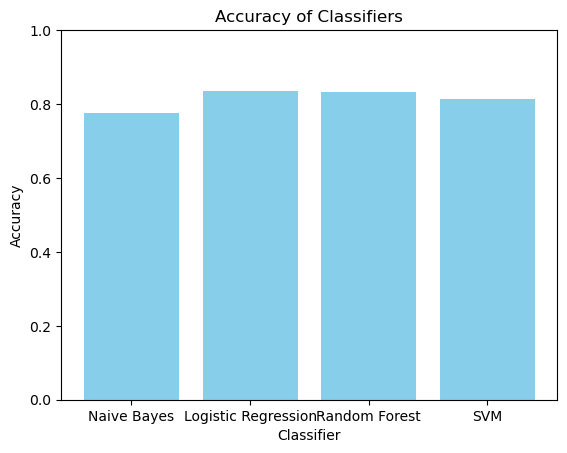

In [311]:
# Plot bar chart for accuracy results
plt.bar(accuracy_results.keys(), accuracy_results.values(), color='skyblue')
plt.title('Accuracy of Classifiers')
plt.xlabel('Classifier')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.show()

#### 4.3 Confusion Matrix

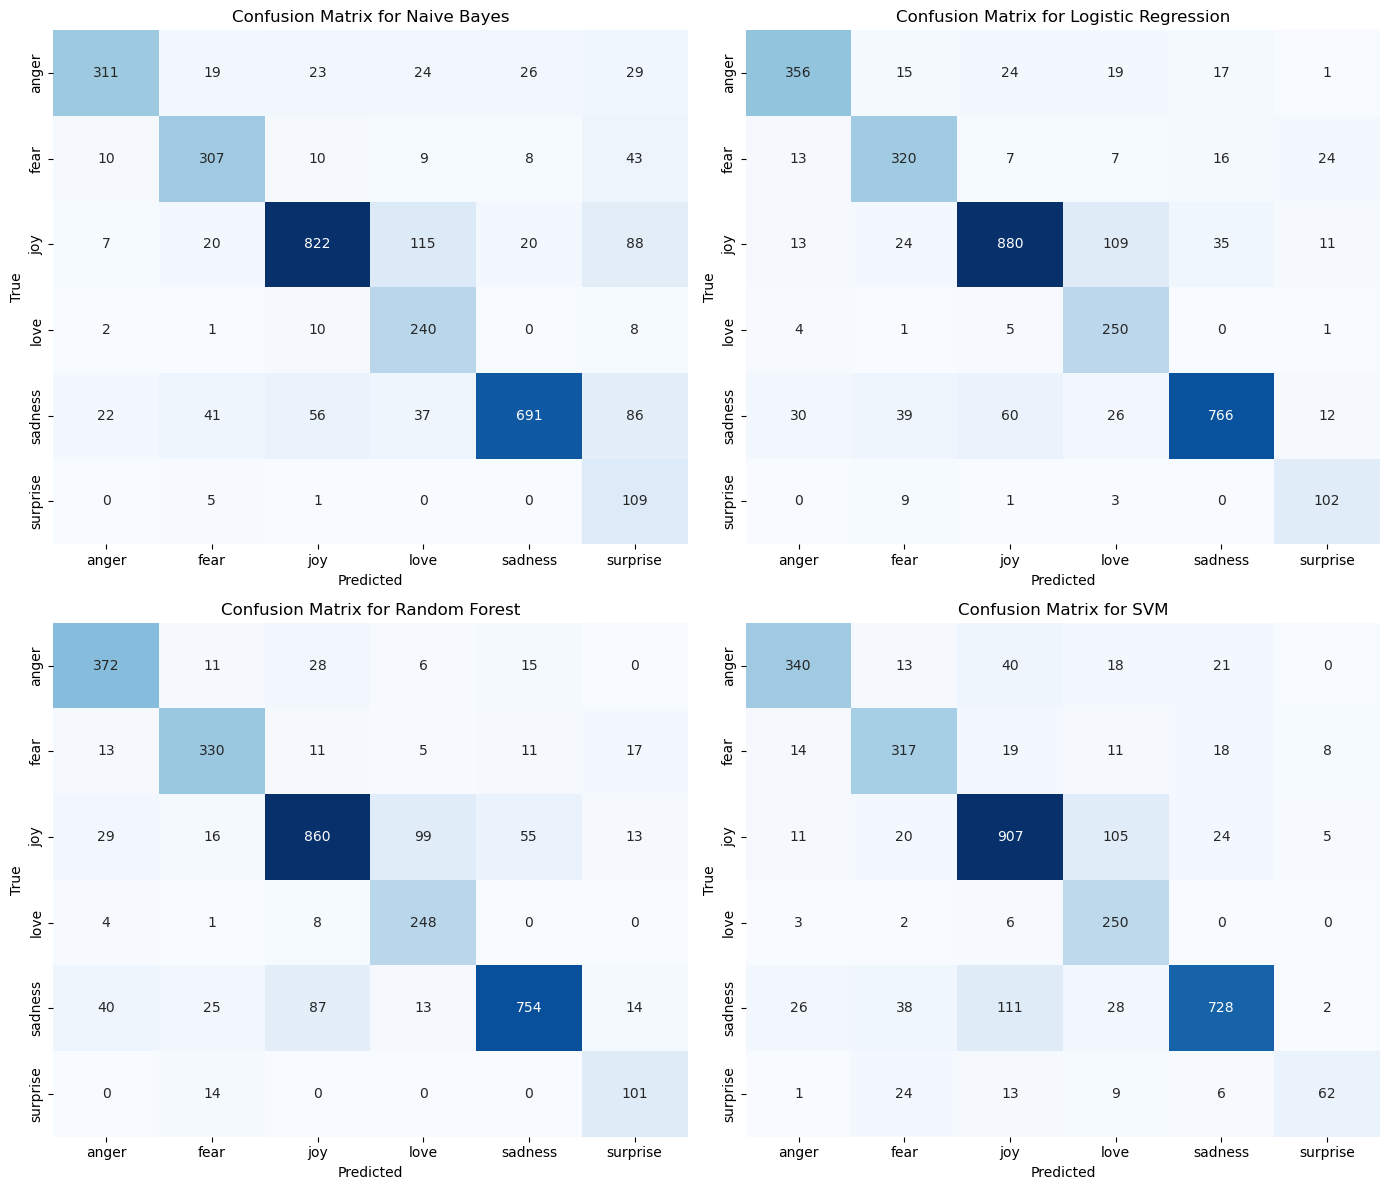

In [314]:
# Set up the plot for confusion matrix heatmaps
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

for i, (name, clf) in enumerate(classifier.items()):
    # Predict using the model
    y_pred_tfidf = clf.predict(X_test_tfidf)
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred_tfidf)
    
    # Plot confusion matrix as a heatmap
    ax = axes[i//2, i%2]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax,
                xticklabels=[emotion_labels[i] for i in range(6)], 
                yticklabels=[emotion_labels[i] for i in range(6)])
    ax.set_title(f'Confusion Matrix for {name}')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')

# Adjust layout for confusion matrix subplots
plt.tight_layout()
plt.show()

### 5. Discussion

**1. Naive Bayes**
* Accuracy: 0.66 (66.19%)
* Performance:
    * Naive Bayes shows a strong performance in recognizing "joy" and "sadness" with high recall for these classes. For "joy", the recall is very high at 0.99, meaning almost all joyful instances are correctly identified.
    * However, it struggles significantly with "anger", "fear", "love", and especially "surprise", where the recall is extremely low (0.01). This suggests Naive Bayes has difficulty distinguishing between more nuanced emotions.
    * F1-scores: Moderate for "joy" (0.74) and "sadness" (0.80), but very low for others, indicating poor balance between precision and recall.
* Naive Bayes shows the most confusion, particularly between "joy" and other emotions like "anger" and "fear."

**2. Logistic Regression**
* Accuracy: 0.86 (86.19%)
* Performance:
    * Logistic Regression improves accuracy significantly compared to Naive Bayes, showing strong performance across most emotions.
The model is especially effective for "joy" (F1-score: 0.88) and "sadness" (F1-score: 0.92), with a high recall (0.96 and 0.94, respectively), indicating it can reliably identify these emotions.
    * "Anger" and "fear" are also predicted with good precision and recall, but "love" and "surprise" show slightly lower recall (0.61 and 0.47), meaning these are harder for the model to predict accurately.
* Logistic Regression reduces misclassifications significantly, but "love" and "surprise" remain challenging.

**3. Random Forest**
* Accuracy: 0.88 (88.44%)
* Performance:
    * Random Forest outperforms Logistic Regression, achieving the highest accuracy among the models.
    * It performs very well on "joy", "sadness", "fear", and "anger", with F1-scores around or above 0.87.
    * While "love" and "surprise" still show lower recall (0.73 and 0.68), the performance is better than other models for these categories.
    * This model has balanced precision and recall across most emotion categories, making it the best performer overall in this context.
* Random Forest has the best balance overall, especially for harder-to-classify emotions like "love" and "surprise."

**4. Support Vector Machine (SVM)**
* Accuracy: 0.85 (85.28%)
* Performance:
    * SVM performs similarly to Logistic Regression, with very good precision and recall for "anger", "fear", "joy", and "sadness".
    * "Surprise" and "love" have lower recall (0.51 and 0.55), which suggests that like Logistic Regression, SVM struggles with these emotions.
    * Overall, SVM achieves strong scores in major emotion categories like "joy" (F1-score: 0.87) and "sadness" (F1-score: 0.92).
* SVM performs similarly to Logistic Regression but also struggles with "love" and "surprise."

**Overall Insights**
* Best Model: Random Forest shows the highest accuracy (88.44%) and the best overall balance between precision and recall for most emotions.
* Challenges: Across all models, "love" and "surprise" are more difficult to predict accurately, with lower recall and F1-scores. This could be due to the lower frequency of these emotions in the dataset or their nuanced nature.
* Naive Bayes Limitations: Naive Bayes, while effective for simple tasks, struggles with more complex emotions and shows poor performance on the less common categories like "surprise" and "love".

In [317]:
# Sample input phrase for prediction
sample_phrase = ["I'm feeling so excited and happy today!"]

# Transform the sample phrase into the same TF-IDF format used for training
sample_phrase_tfidf = tfidfvectorizer.transform(sample_phrase)

# Use the trained Random Forest model to predict the emotion
predicted_emotion_label = classifier['Random Forest'].predict(sample_phrase_tfidf)

# Mapping the numerical label back to the emotion
emotion_mapping = {0: 'anger', 1: 'fear', 2: 'joy', 3: 'love', 4: 'sadness', 5: 'surprise'}
predicted_emotion = emotion_mapping[predicted_emotion_label[0]]

# Output the predicted emotion
print(f"The predicted emotion for the phrase '{sample_phrase[0]}' is: {predicted_emotion}")

The predicted emotion for the phrase 'I'm feeling so excited and happy today!' is: joy
